In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import joblib

# Load the dataset
file_path = '../dataset/BodyFat - Extended.csv'
data = pd.read_csv(file_path)

data = data[data['Sex'] == 'F']

# Separate features and target variable
X = data[['Height', 'Neck', 'Abdomen']]
y = data["BodyFat"]

# Normalize the numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
joblib.dump(scaler, '../scalers/women_scaler.joblib')

['../scalers/women_scaler.joblib']

In [2]:
checkpoint_filepath = '../models/men_best_model_weights.h5'
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_best_only=True,
    monitor='val_mean_absolute_error',
    mode='min',          # Save the model with minimum mean absolute error
    verbose=1
)

# Define the deep learning model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(256, activation='relu'),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')  # Output layer for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

In [3]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=16,
    callbacks=[checkpoint_callback],
    verbose=1
)

Epoch 1/100
1/8 [==>...........................] - ETA: 14s - loss: 566.5793 - mean_absolute_error: 22.9495
Epoch 1: val_mean_absolute_error improved from inf to 17.97843, saving model to ../models/men_best_model_weights.h5
8/8 [==============================] - 2s 68ms/step - loss: 477.3602 - mean_absolute_error: 21.0241 - val_loss: 367.7954 - val_mean_absolute_error: 17.9784
Epoch 2/100
1/8 [==>...........................] - ETA: 0s - loss: 439.3492 - mean_absolute_error: 19.8320
Epoch 2: val_mean_absolute_error improved from 17.97843 to 9.75123, saving model to ../models/men_best_model_weights.h5
8/8 [==============================] - 0s 21ms/step - loss: 222.6415 - mean_absolute_error: 12.8171 - val_loss: 208.0731 - val_mean_absolute_error: 9.7512
Epoch 3/100
1/8 [==>...........................] - ETA: 0s - loss: 150.7992 - mean_absolute_error: 9.3087
Epoch 3: val_mean_absolute_error improved from 9.75123 to 9.59241, saving model to ../models/men_best_model_weights.h5
8/8 [========

In [4]:
# Evaluate the model on the test set
model.load_weights(checkpoint_filepath)
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)

print(f"Test Loss: {test_loss}")
print(f"Test MAE: {test_mae}")

Test Loss: 14.867164611816406
Test MAE: 2.8949899673461914


83.78% of predictions have a difference of lower than three with actual values.


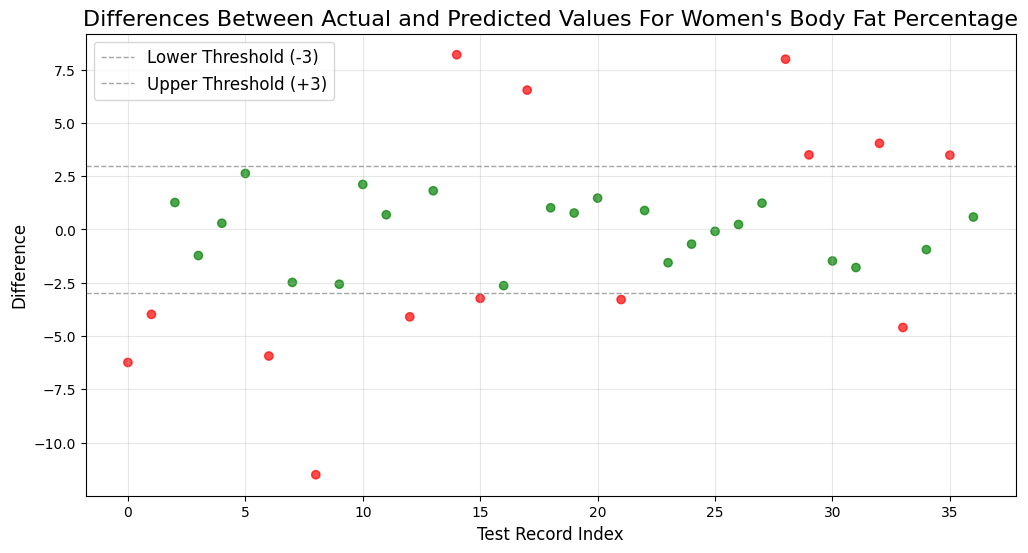

In [5]:
# Predict values for the test set
predicted_values = model.predict(X_test, verbose=0).flatten()
actual_values = y_test.values

# Calculate the differences (residuals)
differences = actual_values - predicted_values


lower_than_3 = 0
for diff in differences:
    if diff <= 3:
        lower_than_3 += 1
        
print(f'{lower_than_3 / len(differences) * 100:.2f}% of predictions have a difference of lower than three with actual values.')

# Define colors based on the threshold
colors = ['green' if -3 <= diff <= 3 else 'red' for diff in differences]

# Plot the differences as scatter points
plt.figure(figsize=(12, 6))
plt.scatter(range(len(differences)), differences, c=colors, alpha=0.7)
plt.axhline(y=-3, color='gray', linestyle='--', linewidth=1, alpha=0.7, label='Lower Threshold (-3)')
plt.axhline(y=3, color='gray', linestyle='--', linewidth=1, alpha=0.7, label='Upper Threshold (+3)')

# Add labels and legend
plt.title('Differences Between Actual and Predicted Values For Women\'s Body Fat Percentage', fontsize=16)
plt.xlabel('Test Record Index', fontsize=12)
plt.ylabel('Difference', fontsize=12)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.show()

In [6]:
# Select a random test record
test_index = np.random.randint(0, len(X_test))  # Random index from the test set
test_record = X_test[test_index].reshape(1, -1)  # Reshape for prediction
actual_value = y_test.iloc[test_index]  # Corresponding actual value

# Predict using the model
predicted_value = model.predict(test_record, verbose=0)

# Print the results
print(f"Predicted Body Fat Percentage: {predicted_value[0][0]:.2f}")
print(f"Actual Body Fat Percentage: {actual_value:.2f}")
print(f"Differece: {abs(predicted_value[0][0] - actual_value):.2f}")

Predicted Body Fat Percentage: 17.24
Actual Body Fat Percentage: 18.13
Differece: 0.89
